In [2]:
# data config libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

# display config libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# openCV
import cv2

# Machine Learning
import xgboost as xgb


# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import custom packages and utility files

from DataUtility import dataUtils
skinDataUtils = dataUtils()

from DataUtility import SKIN_CANCER_TUMOR_TYPE

from ModelTrainer import ModelTrainer
ModelTrainer = ModelTrainer()

from ModelValidator import ValidateModel
ValidateSkinCancerClassfier = ValidateModel()

## Image Data Exploration

### 1. Malignant Images

<br>

***Samples of the malignant (cancerous) tumors...***

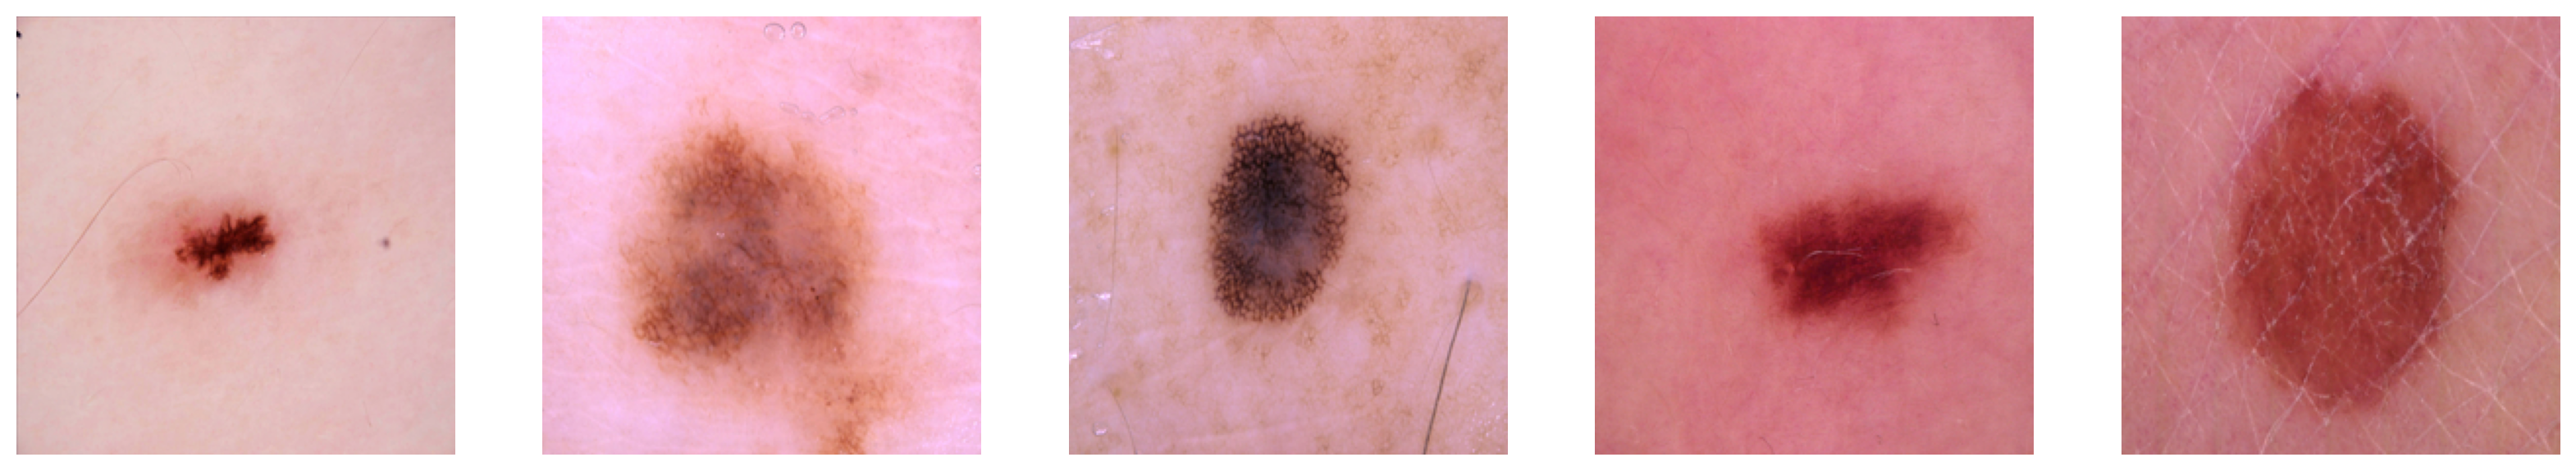

In [4]:
skinDataUtils.PrintMarkdownText('***Samples of the malignant (cancerous) tumors...***')
skinDataUtils.ReadAndDisplayInputImages(SKIN_CANCER_TUMOR_TYPE.BENIGN.value, 5)

### 2. Benign Images

<br>

***Samples of the benign (non-cancerous) tumors...***

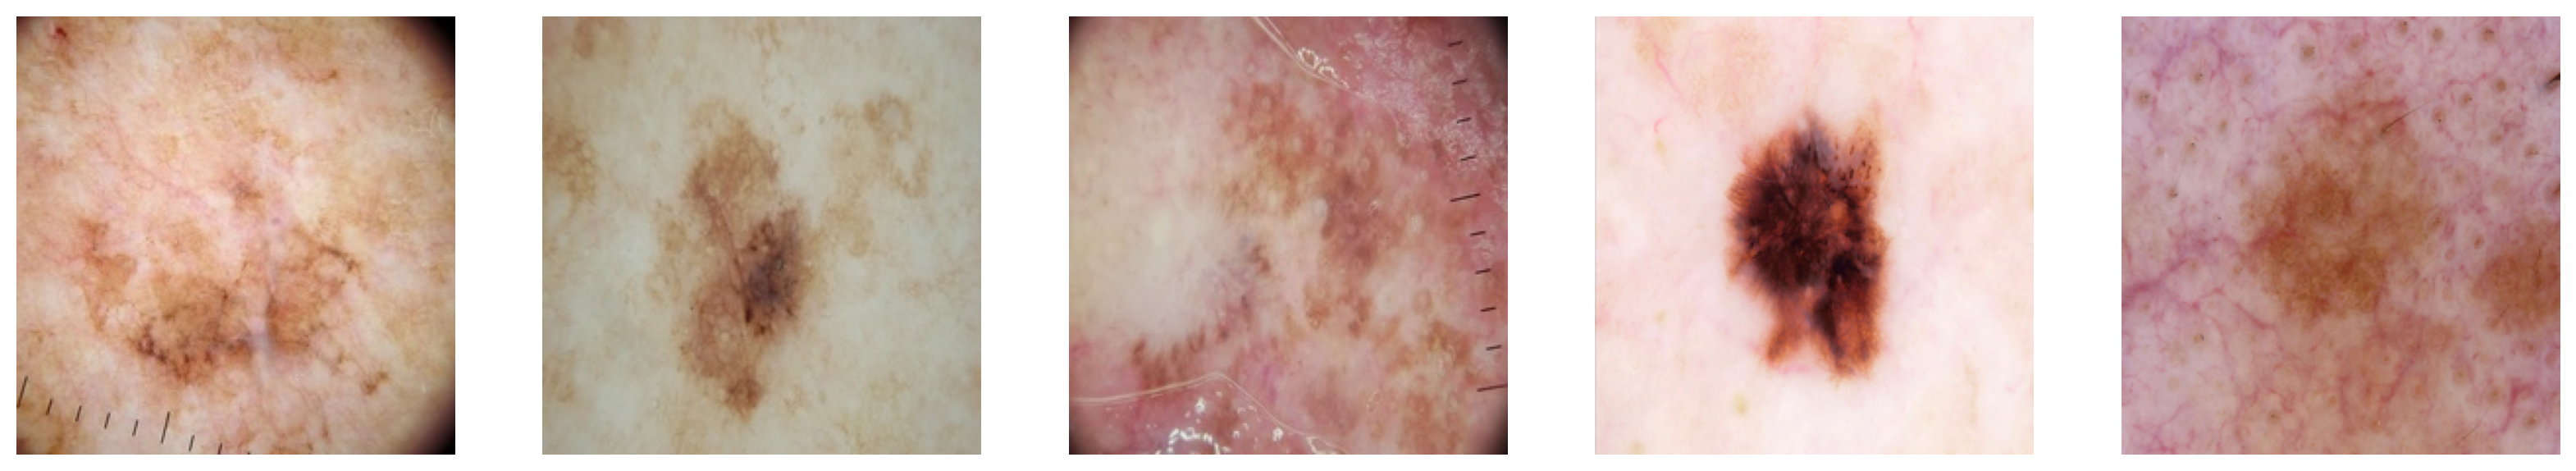

In [5]:
skinDataUtils.PrintMarkdownText('***Samples of the benign (non-cancerous) tumors...***')
skinDataUtils.ReadAndDisplayInputImages(SKIN_CANCER_TUMOR_TYPE.MALIGNANT.value, 5)

### Data Labelling

The images we have are un-labelled data. Deep learnins systems require proper annotated data to be able to learn the specific representations of each class and perform the job on unseen real time data. So, before proceeding with furtehr analysis we will first assign labels to our data. We have 2 class of images -

1. **Benign**

2. **Malignant**

***Malignant (cancerous)*** will be assigned values of 1 and ***Benign (non-cancerous)*** will be assigned the value 0.

In [6]:
skinCancer_df = skinDataUtils.GetLabelledSkinCancerData()

skinDataUtils.PrintMarkdownText('***Labelled skin cancer images...***')
skinCancer_df.head()

<br>

***Labelled skin cancer images...***

filename      label
0   ISIC Skin Cancer/images/malignant\507.jpg  Malignant
1  ISIC Skin Cancer/images/malignant\1465.jpg  Malignant
2      ISIC Skin Cancer/images/benign\820.jpg     Benign
3      ISIC Skin Cancer/images/benign\311.jpg     Benign
4  ISIC Skin Cancer/images/malignant\1068.jpg  Malignant

In [7]:
skinDataUtils.PrintMarkdownText('***Annotated skin cancer dataframe Info...***')
skinCancer_df.info()

<br>

***Annotated skin cancer dataframe Info...***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297 entries, 0 to 3296
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3297 non-null   object
 1   label     3297 non-null   object
dtypes: object(2)
memory usage: 51.6+ KB


<br>

***Sample Annotated Benign & Malignant Images...***

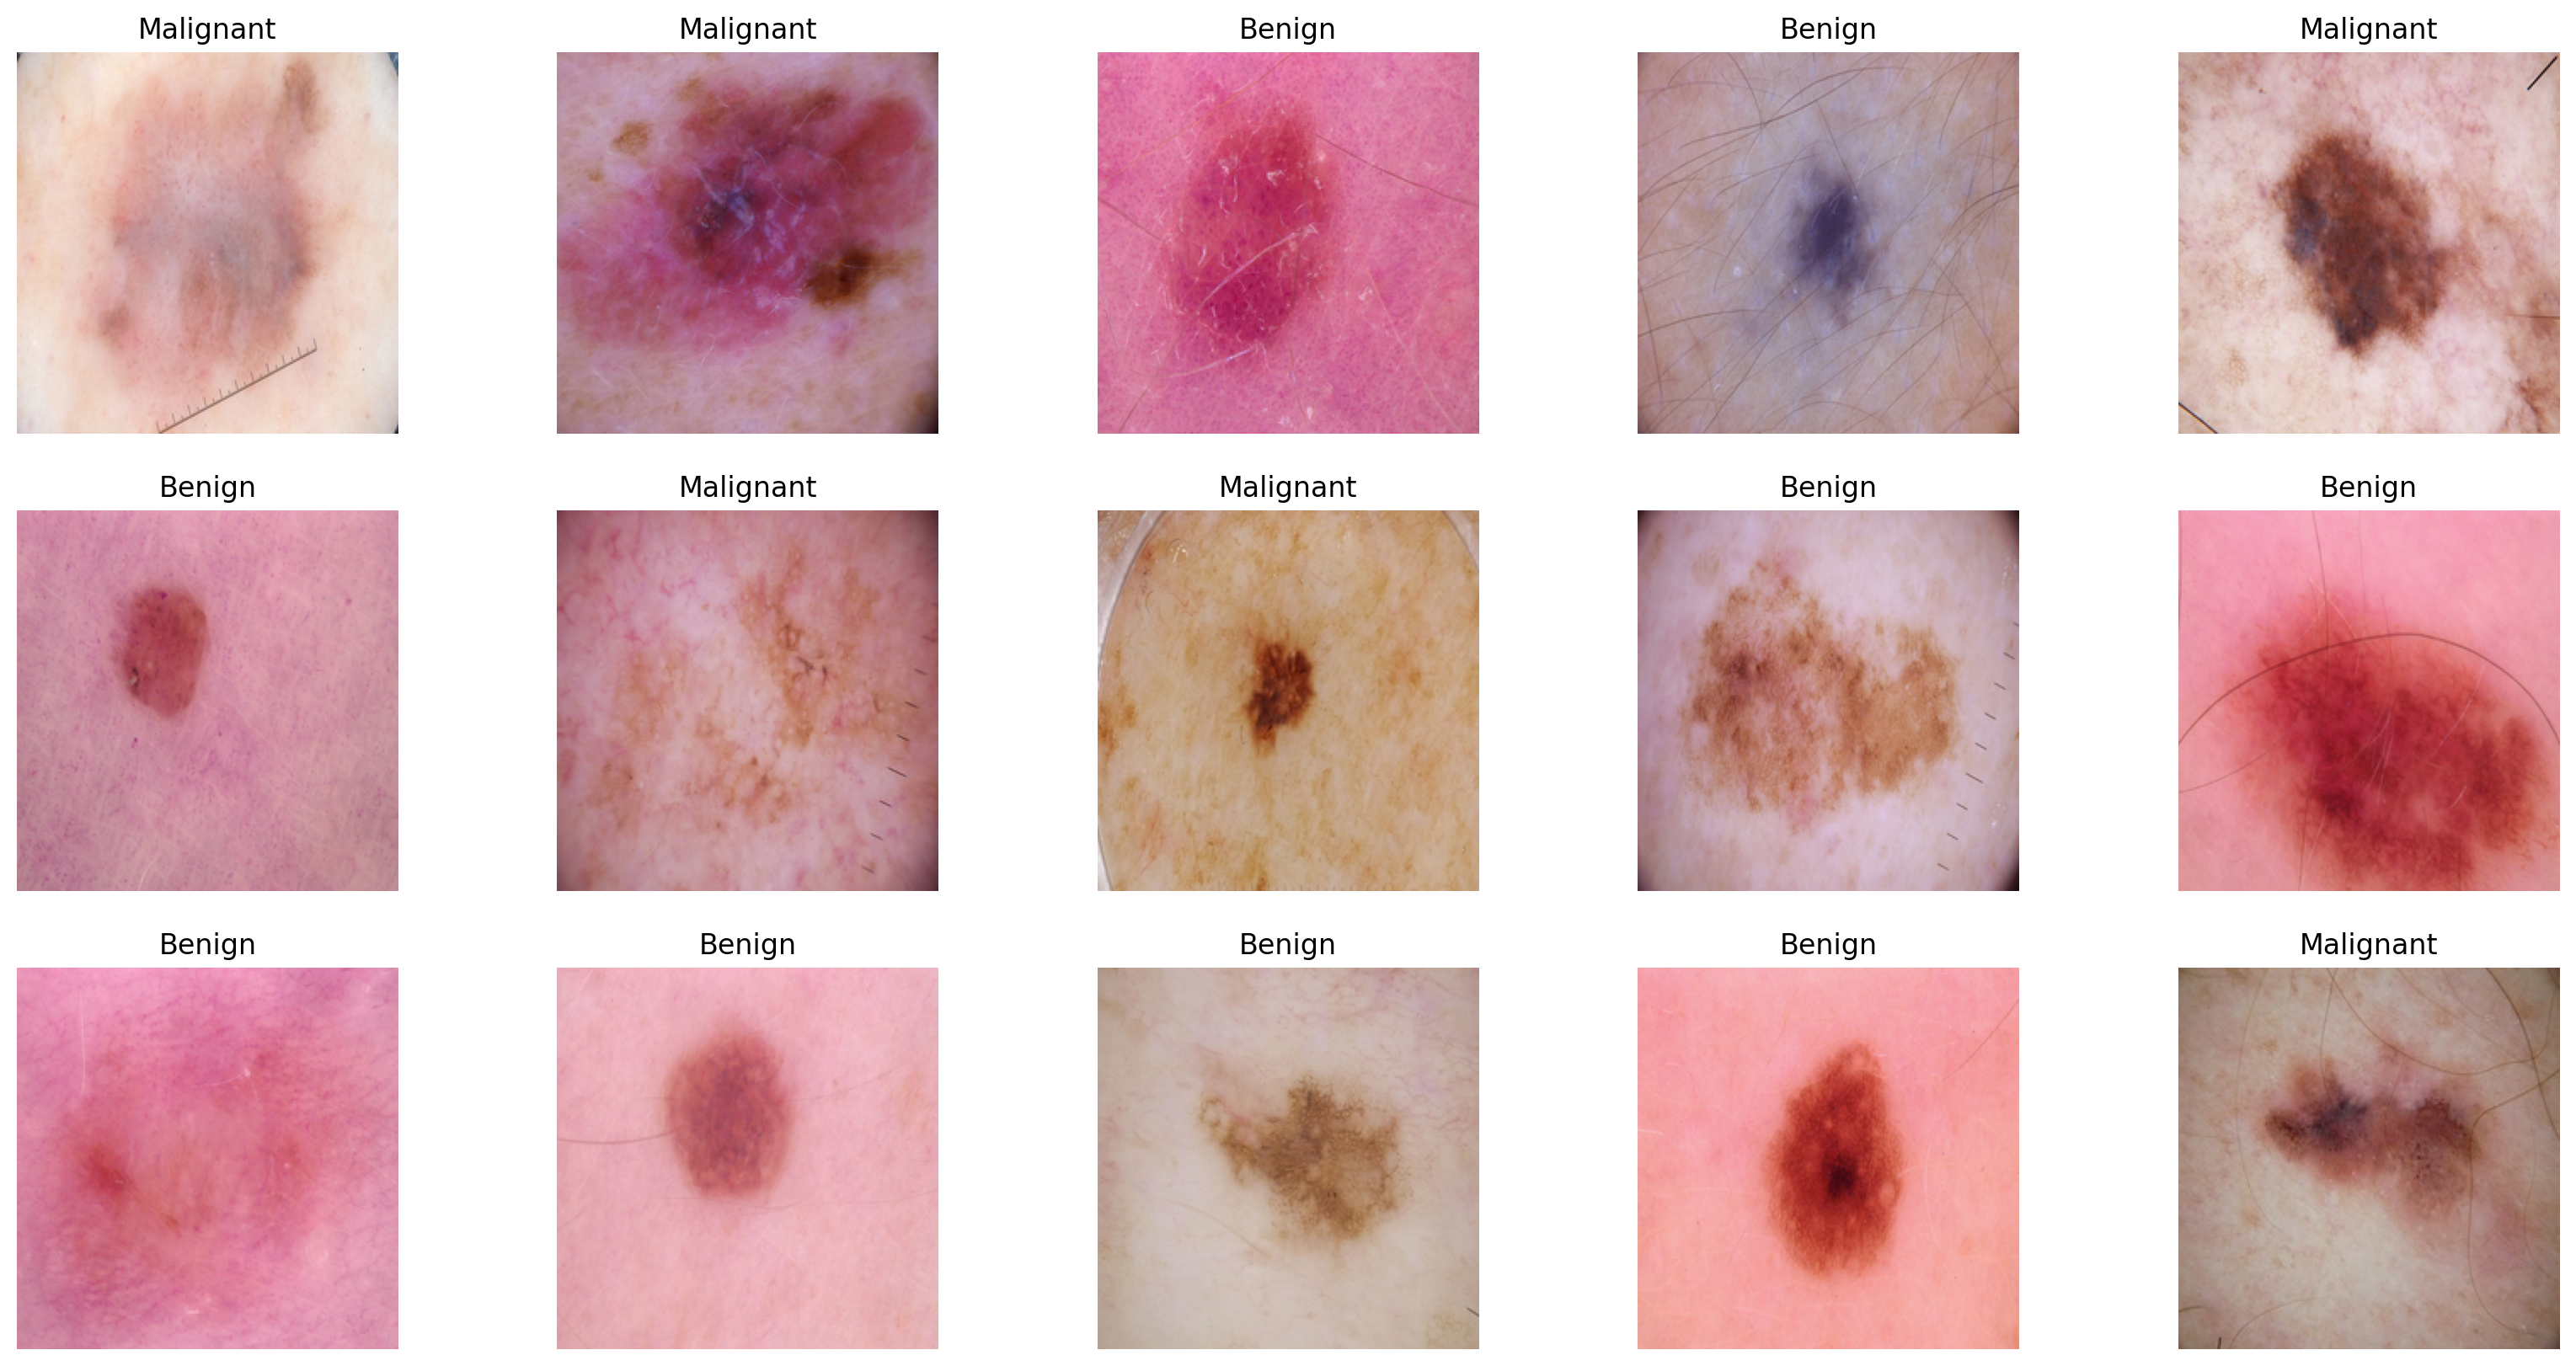

In [8]:
skinDataUtils.PrintMarkdownText('***Sample Annotated Benign & Malignant Images...***')
skinDataUtils.DisplayAnnotatedImages(skinCancer_df, 15)

## Image Dimensions

### 1. Malignant Images

In [9]:
skinDataUtils.PrintMarkdownText('***Shape Distribution for Malignant Images:***')
skinDataUtils.GetAllImageShape(SKIN_CANCER_TUMOR_TYPE.MALIGNANT.value)

<br>

***Shape Distribution for Malignant Images:***

Counter({(224, 224, 3): 1497})

### 2. Benign Images

In [10]:
skinDataUtils.PrintMarkdownText('***Shape Distribution for Benign Images:***')
skinDataUtils.GetAllImageShape(SKIN_CANCER_TUMOR_TYPE.BENIGN.value)

<br>

***Shape Distribution for Benign Images:***

Counter({(224, 224, 3): 1800})

All the images are of uniform dimension --> **(224, 224, 3)**

## Test Train Validation Split

In [18]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(skinCancer_df['filename'].values,
                                                                      skinCancer_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

In [19]:
skinDataUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 2802 samples
 -- Test Set Length: 495 samples


In [21]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

skinDataUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'Benign': 1549, 'Malignant': 1253}) 

Test Data: Counter({'Benign': 251, 'Malignant': 244})


##  Load All Images 
### Train, Test and Validation

In [47]:
# skinDataUtils.ReadAllImages

train_data = skinDataUtils.ReadAllImages(imageList = train_files, resizeImage = True, newImageSize = (135, 135))
test_data = skinDataUtils.ReadAllImages(imageList = test_files, resizeImage = True, newImageSize = (135, 135))

In [23]:
X_test = test_data / 255.

In [49]:
train_data = train_data.reshape(train_data.shape[0], -1)


In [54]:
test_data = test_data.reshape(test_data.shape[0], -1)

### Label Encoding

Encode categorical values **(`'Benign' & 'Malingant'`)** to convert to the machine readable and interpretable values which would be **Benign - 0** and **Malignant - 1**.

In [26]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_test = lbl_encoder.transform(test_labels)

skinDataUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Benign', 'Benign', 'Benign', 'Benign', 'Benign'] 

Encoded Train Labels:     [0 0 0 0 0]


## Model Training and Validation

In [27]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

In [51]:
xgb_model.fit(train_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
import pickle

with open("Xgboost_Prediction", 'wb') as file:
    pickle.dump(xgb_model, file)

### Model Testing

In [55]:
y_pred = xgb_model.predict(test_data)

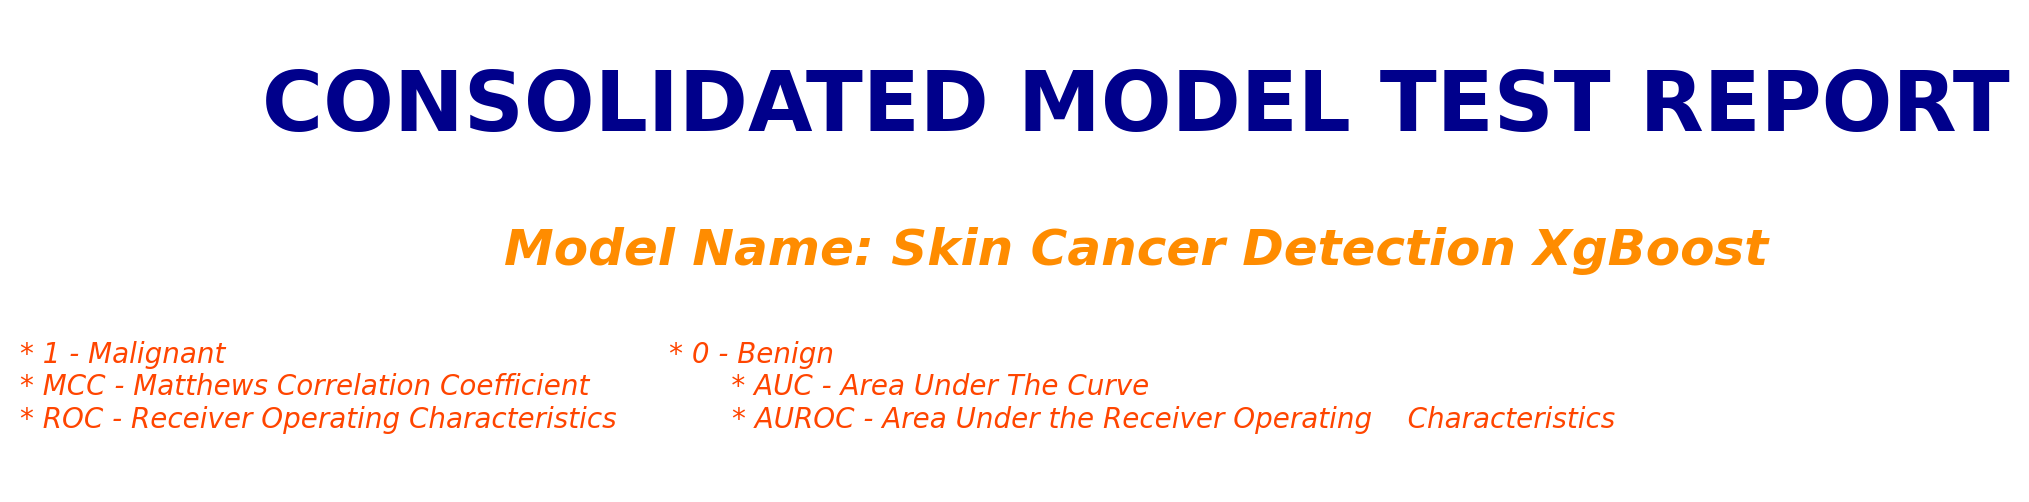

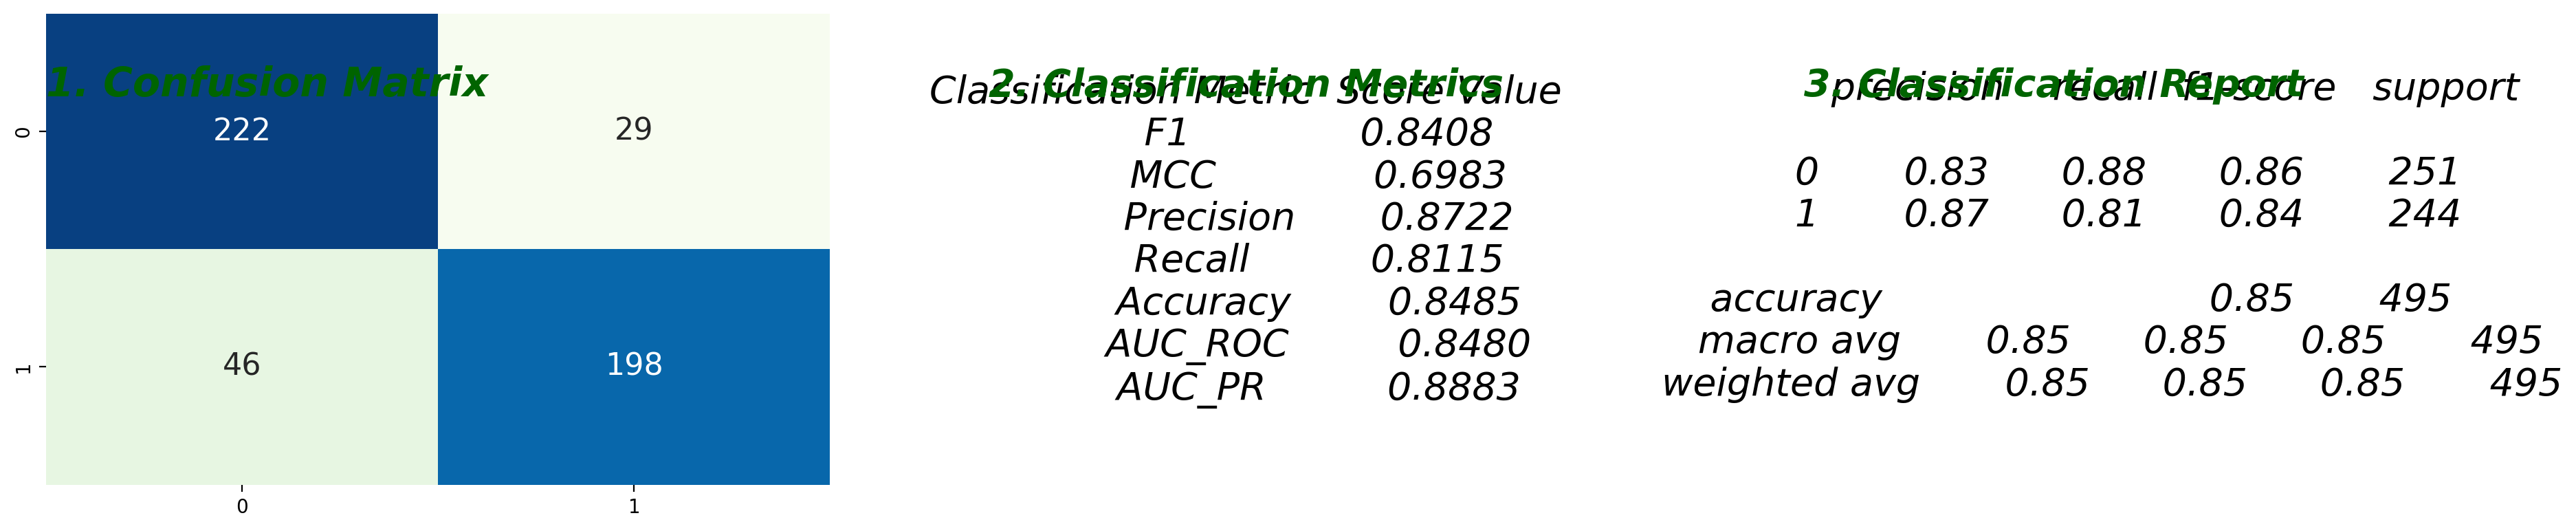

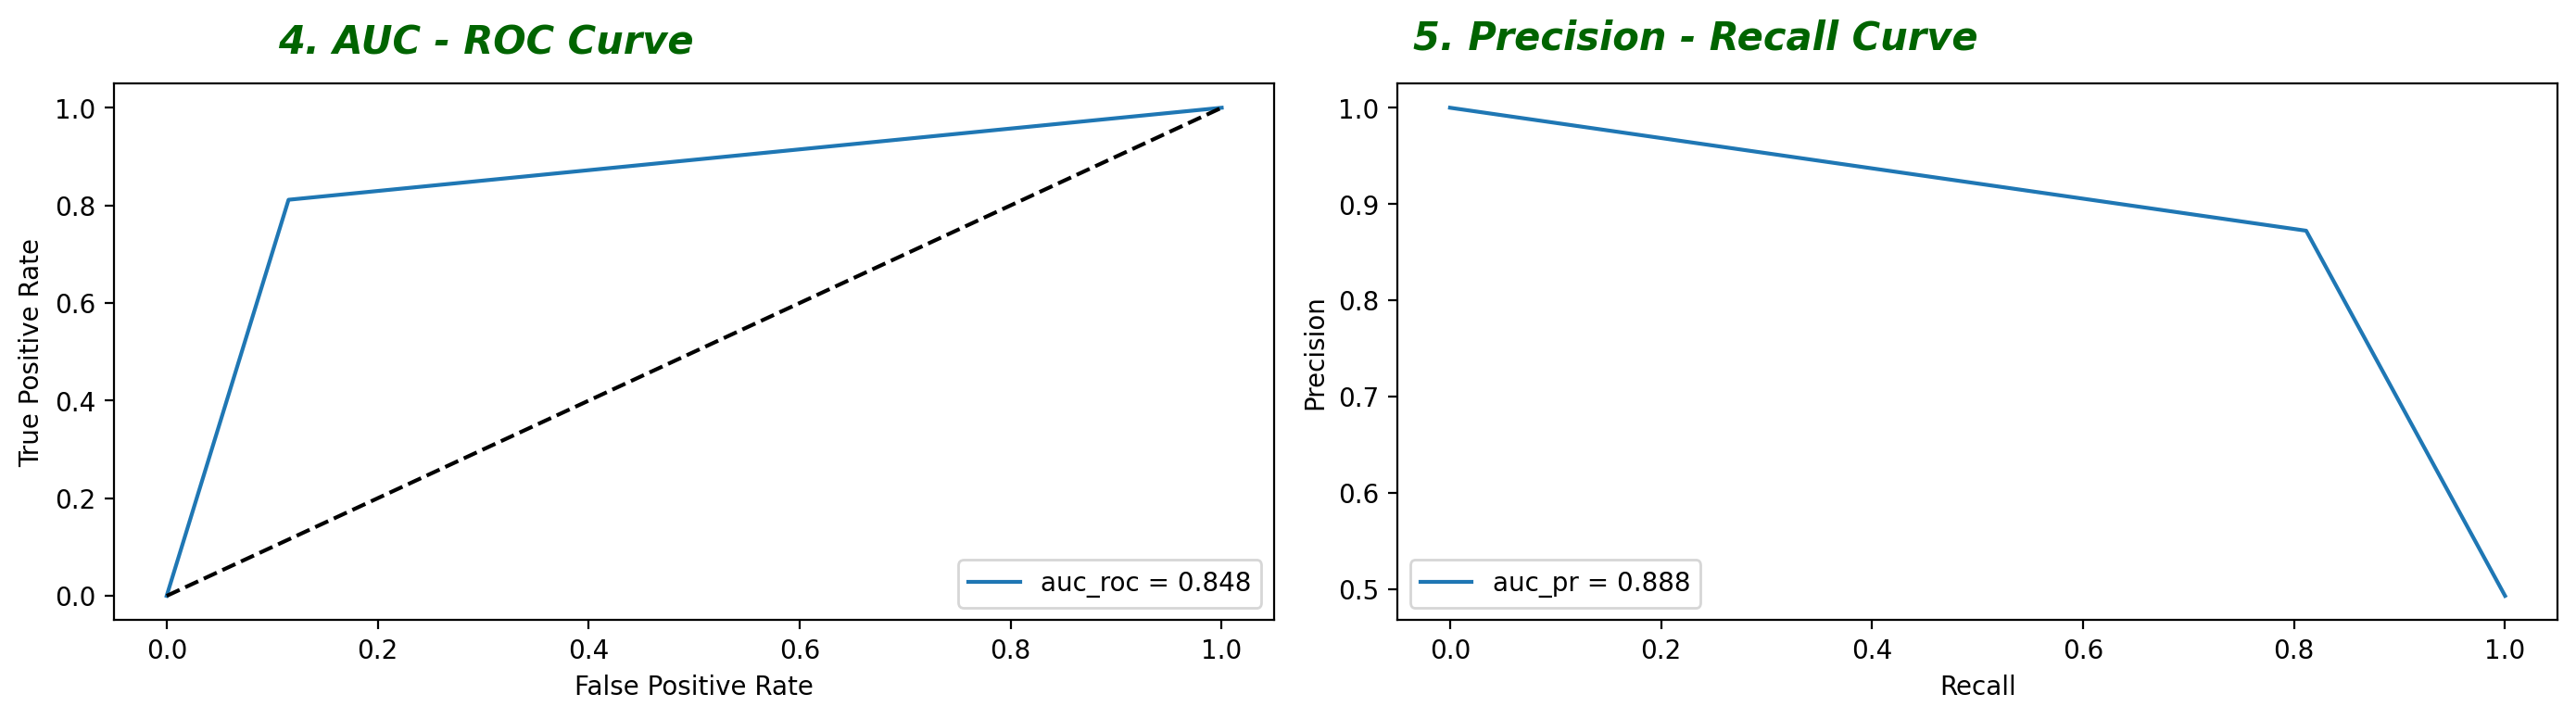

In [57]:
ValidateSkinCancerClassfier.Generate_Model_Test_Classification_Report(y_test, y_pred, "Skin Cancer Detection XgBoost")

<br>

***Model test results of 16 random test images...***

IndexError: invalid index to scalar variable.

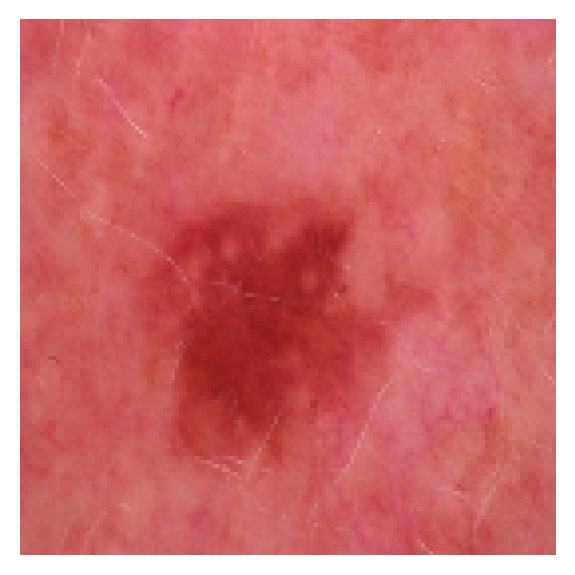

In [61]:
ValidateSkinCancerClassfier.PlotModelPredictionsOnRandomTestImages(X_test, y_test, y_pred)

## Gradient - Class Activation Maps (GradCAM) - Viz

In [26]:
from GradCamUtility import GradCamUtils
gCam = GradCamUtils(xgb_model, "block5_conv4")

In [ ]:
img = cv2.cvtColor(X_test[98], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# get the probability of this tumor being malignant
probability = xgb_model.predict(imgAsTensor)
print("Probability of the tumor being malignant is:", probability[0][0])

# generate the heatmap
heatmap = gCam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = gCam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
gCam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)

In [ ]:
img = cv2.cvtColor(X_test[45], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# get the probability of this tumor being malignant
probability = xgb_model.predict(imgAsTensor)
print("Probability of the tumor being malignant is:", probability[0][0])

# generate the heatmap
heatmap = gCam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = gCam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
gCam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)

In [ ]:
img = cv2.cvtColor(X_test[25], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# get the probability of this tumor being malignant
probability = xgb_model.predict(imgAsTensor)
print("Probability of the tumor being malignant is:", probability[0][0])

# generate the heatmap
heatmap = gCam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = gCam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
gCam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)

In [ ]:
img = cv2.cvtColor(X_test[32], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# get the probability of this tumor being malignant
probability = xgb_model.predict(imgAsTensor)
print("Probability of the tumor being malignant is:", probability[0][0])

# generate the heatmap
heatmap = gCam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = gCam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
gCam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)